In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize
import copy
from scipy.optimize import leastsq
import scipy 

import logging


In [4]:
import qt3utils.experiments.ramsey
import qt3utils.experiments.cwodmr
import qt3utils.experiments.podmr
import qt3utils.experiments.rabi

from qt3utils.experiments.pulsers.pulseblaster import PulseBlasterRamHahnDD
from qt3utils.experiments.pulsers.pulseblaster import PulseBlasterCWODMR
from qt3utils.experiments.pulsers.pulseblaster import PulseBlasterPulsedODMR
from qt3utils.experiments.pulsers.pulseblaster import PulseBlasterHoldAOM
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

import nipiezojenapy
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
import qt3utils.nidaq.config

In [5]:
import pickle
def save_file(name, data):
    with open(name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_file(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [6]:
logging.basicConfig(level=logging.WARNING)

In [7]:
qt3utils.experiments.cwodmr.logger.setLevel(logging.INFO)

# Create objects to control hardware

In [8]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [9]:
aom_hold = PulseBlasterHoldAOM()

In [11]:
aom_hold.program_pulser_state()
aom_hold.start() #do this to during confocal san

In [12]:
cwodmr_pulser = PulseBlasterCWODMR(clock_period = 1e-6)

In [13]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

# Confocal Scan
Either run a scan here in the notebook, or use qt3scan and save. qt3scan was used and we load the scan here.

Laser power was ~25 microWatts (according the to photodiode). This has a large uncertainty, it appears, as repeated readings range +- 5 microWatts


Todo -- calibrate with external power meter

<IPython.core.display.Javascript object>


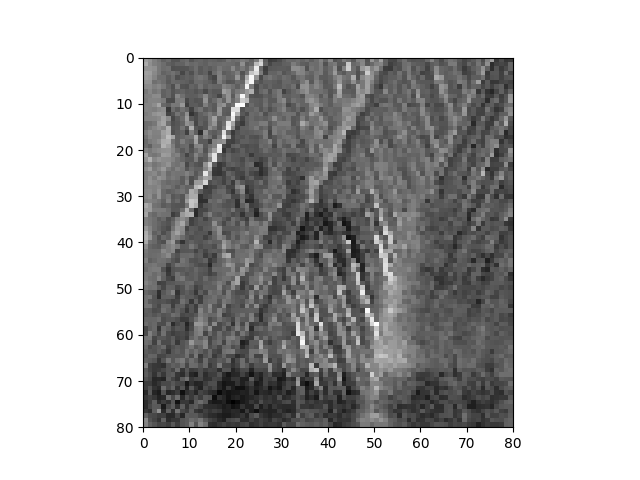

In [15]:
scan_file = 'large_scan_x0t80_y0t80.npy'
confocal_scan = np.load(scan_file)
plt.figure()
plt.imshow(confocal_scan, cmap='Greys_r', extent = [0,80,80,0])

In [16]:
cwodmr_exp = qt3utils.experiments.cwodmr.CWODMR(cwodmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-10)

In [17]:
def scan_with_powers(experiment, rf_powers, line_widths = {}, N_cycles = 10000, random_order = False):

    for a_pow in rf_powers:
        print(a_pow)
        experiment.rf_power = a_pow

        scan_data = experiment.run(N_cycles=N_cycles, random_order = random_order)

        scan_data = np.array(scan_data)
        line_widths[a_pow] = {'scan':scan_data, 
                              'experiment_conditions':experiment.experimental_conditions()}
        
       
    return line_widths


In [18]:
def plot_contrast_scan(scan, xlabel = 'frequency [Hz]', figsize = (8,4), marker = 'o-'):
    scan = np.array(scan)

    x_data = scan[:, 0]
    y_data = scan[:, 1]

    plt.figure(figsize=figsize)
    plt.plot(x_data, y_data, marker, label='Data')

    plt.xlabel(xlabel)

In [27]:
cwodmr_exp.pulser.rf_width = 4e-3
cwodmr_exp.pulser.clock_period = 100e-6
cwodmr_exp.freq_low = 2780e6
cwodmr_exp.freq_high = 2800e6
cwodmr_exp.freq_step = 0.2e6

In [28]:
cwodmr_exp.experimental_conditions()

{'freq_low': 2780000000.0,
 'freq_high': 2800000000.0,
 'freq_step': 200000.0,
 'rf_power': -25,
 'pulser': {'rf_width': 0.004, 'clock_period': 0.0001}}

In [29]:
line_widths = scan_with_powers(cwodmr_exp, [-25], N_cycles = 500)

-25


INFO:qt3utils.experiments.cwodmr:RF frequency: 2780000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2780200000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2780400000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2780600000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2780800000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2781000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2781200000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2781400000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2781600000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2781800000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2782000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2782200000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2782400000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2782600000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2782800000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27830000

<IPython.core.display.Javascript object>


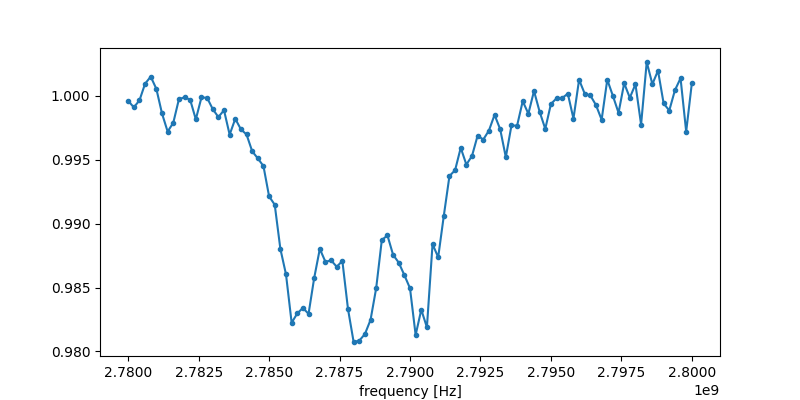

In [30]:
plot_contrast_scan(line_widths[-25]['scan'], marker = '.-')

In [32]:
save_data_name = 'cwodmr_single_peak_scan_oct31.2022.pickle'

save_file(save_data_name, line_widths)

In [66]:
# some fitting functions

def lorentzian( x, center, amplitude, width ):
    return amplitude * width**2 / ( width**2 + ( x - center )**2)

def multi_lorentz( x, *params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def _2_lorentz_fixed_peak_diff(x, *params):
        offset = params[0]
        return offset + lorentzian(x, params[1], params[2], params[3]) + lorentzian(x, params[1] + params[4], params[5], params[6])

    
def _3_lorentz_same_amp_and_width(x, *params):
    output = params[0]
    output += lorentzian(x, params[1], params[2], params[3])
    output += lorentzian(x, params[4], params[2], params[3])
    output += lorentzian(x, params[5], params[2], params[3])
    return output

    
def res_multi_lorentz(xData, yData, *params):
    diff = [ multi_lorentz( x, *params ) - y for x, y in zip( xData, yData ) ]
    return diff

def fit_triple_lorentz(x, y):

    amp1 = 1
    cen1 = np.mean(x)-1
    cen2 = np.mean(x)
    cen3 = np.mean(x)+1
    wid1 = 1
    
    params = [0, cen1, amp1, wid1, cen2, cen3]
    bounds = (len(params)*[-np.inf], len(params)*[np.inf])
    #bounds[0][0] = -1
    #bounds[1][0] = 1
    a_min = np.min(x)
    a_max = np.max(x)
    #a_min = 2782
    #a_max = 2792
    bounds[0][1], bounds[1][1] = a_min, a_max
    bounds[0][4], bounds[1][4] = a_min, a_max
    bounds[0][5], bounds[1][5] = a_min, a_max
    
    bounds[0][2], bounds[1][2] = 0, 50
    bounds[0][3], bounds[1][3] = 0, 2


    p_opt, p_cov = scipy.optimize.curve_fit(_3_lorentz_same_amp_and_width, x, y, 
                                            p0=params, 
                                            maxfev = 10000, 
                                            bounds = bounds)
    return p_opt, p_cov

def fit_scans(line_widths, fixed_delta = None):

    for a_pow, res in line_widths.items():
        print(a_pow)
      
        scan_data = res['scan']
        
        
        xData = scan_data[:, 0]*1e-6 #in MHz
        yData = scan_data[:, 1]

        #drop nans from the data
        xData = xData[~np.isnan(yData)]
        yData = yData[~np.isnan(yData)]

        yData = 1 - yData
        yData = yData*100
    
        optimized_p, cov_p = fit_triple_lorentz(xData, yData)

        p_errs = np.sqrt(np.diag(cov_p))
        offset = optimized_p[0]
        mean_width = optimized_p[3]
        line_width_sigma = p_errs[3]
        print(optimized_p)
        
        line_widths[a_pow].update({'p_opt': optimized_p,
                              'p_cov':cov_p,
                              'mean_width':mean_width,
                              'mean_width_sigma':line_width_sigma,
                              'x':xData,
                              'y':yData,
                              'scan':scan_data,
                              'fixed_delta':fixed_delta})
        
    return line_widths


def plot_spectrum_and_accumulate_line_widths(line_widths):
    rf_power_line_width = []

    for a_pow, res in line_widths.items():
        fixed_delta = res.get('fixed_delta', None)
        opt_p = copy.deepcopy(res['p_opt'])
        if fixed_delta is not None:
            raise NotImplementedError("not yet supported")
        plot_fit(res['x'], res['y'], opt_p)
        plt.title(f'RF Power = {a_pow}, Line Width = {res["mean_width"]:0.2f} MHz')
        plt.xlabel('frequency [MHz]')
        plt.ylabel('PL loss [percent]')
        rf_power_line_width.append([a_pow, res['mean_width'], res['mean_width_sigma']])

    return rf_power_line_width

def plot_fit(x, y, p_opt):
    plt.figure(figsize=(8,6))
    plt.plot(x, y, 'o-', label='Data')
    plt.plot(x, _3_lorentz_same_amp_and_width(x, *p_opt), 'k--', label='Fit')
    plt.legend()

In [67]:
scans_with_fit_results = fit_scans(line_widths)

-25
[-2.31053770e-02  2.78601461e+03  1.56388158e+00  8.24196113e-01
  2.78819723e+03  2.79039178e+03]


<IPython.core.display.Javascript object>


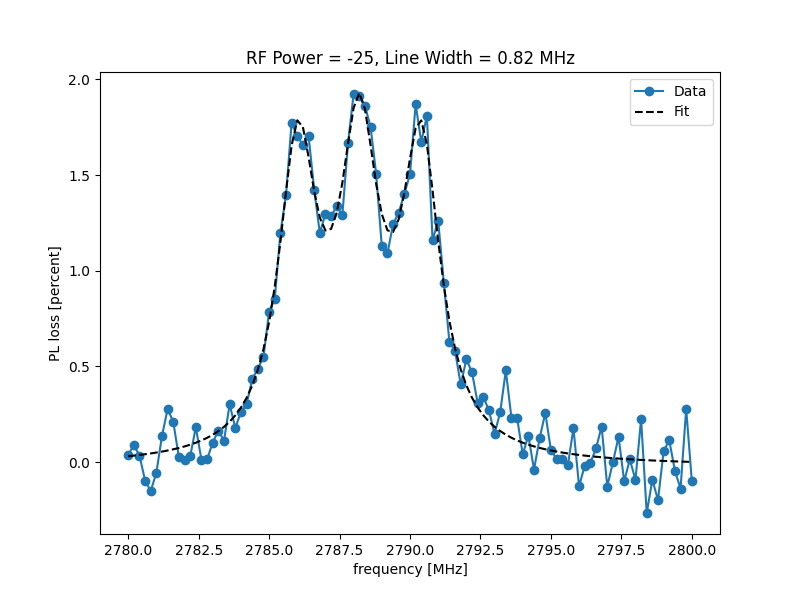

[[-25, 0.824196113341049, 0.03095223506627777]]

In [68]:
plot_spectrum_and_accumulate_line_widths(scans_with_fit_results)

In [71]:
central_frequency = scans_with_fit_results[-25]['p_opt'][4]

In [72]:
np.round(central_frequency*1e6)

2788197230.0

In [75]:
1e6*30e-6*(8e-6 - 1e-7)/1e-7/60

39.49999999999999

In [80]:
qt3utils.experiments.ramsey.Ramsey?

In [100]:
ramsey_pulser = PulseBlasterRamHahnDD(rf_pi_pulse_width = 1e-6, aom_width=50e-6)

In [101]:
ramsey_experiment = qt3utils.experiments.ramsey.Ramsey(ramsey_pulser, rfsynth, nidaq_config,
                                                  rf_power=-25, rf_frequency=2788197230)

In [102]:
qt3utils.experiments.ramsey.logger.setLevel(logging.INFO)


In [103]:
ramsey_experiment.experimental_conditions()

{'tau_low': 1e-06,
 'tau_high': 1e-05,
 'tau_step': 2e-07,
 'rf_power': -25,
 'rf_frequency': 2788197230,
 'pulser': {'rf_pi_pulse_width': 1e-06,
  'aom_width': 5e-05,
  'aom_response_time': 8e-07,
  'post_rf_pad': 1e-07,
  'pre_rf_pad': 1e-07,
  'full_cycle_width': None,
  'free_precession_time': 5e-06,
  'clock_period': 2e-07}}

In [104]:
#ramsey_experiment.pulser.clock_period = 10e-6 

In [105]:
import qt3utils.experiments.common

In [106]:
scan_data = ramsey_experiment.run(N_cycles=1000, post_process_function=qt3utils.experiments.common.aggregate_sum)

INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 1e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 1.2e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 1.4e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 1.6e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 1.8e-06 seconds
C:\Users\adamcox\anaconda3\envs\dev1\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<8F>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\adamcox\anaconda3\envs\dev1\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<90>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\adamcox\anaconda3\envs\dev1\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<91>" was not 

INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 9.2e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 9.4e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 9.6e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 9.8e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 1e-05 seconds
c:\users\adamcox\qt3-software-packages\qt3-utils\src\qt3utils\experiments\ramsey.py:231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


<IPython.core.display.Javascript object>


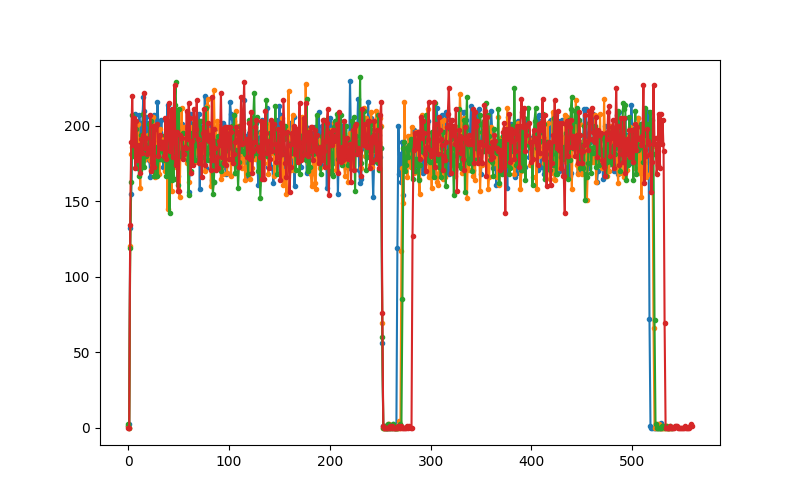

In [119]:

plt.figure(figsize=(8, 5))
a_scan = scan_data[0]
plt.plot(a_scan[1], '.-', label='Data')

a_scan = scan_data[4]
plt.plot(a_scan[1], '.-', label='Data')

a_scan = scan_data[5]
plt.plot(a_scan[1], '.-', label='Data')

a_scan = scan_data[15]
plt.plot(a_scan[1], '.-', label='Data')

<IPython.core.display.Javascript object>


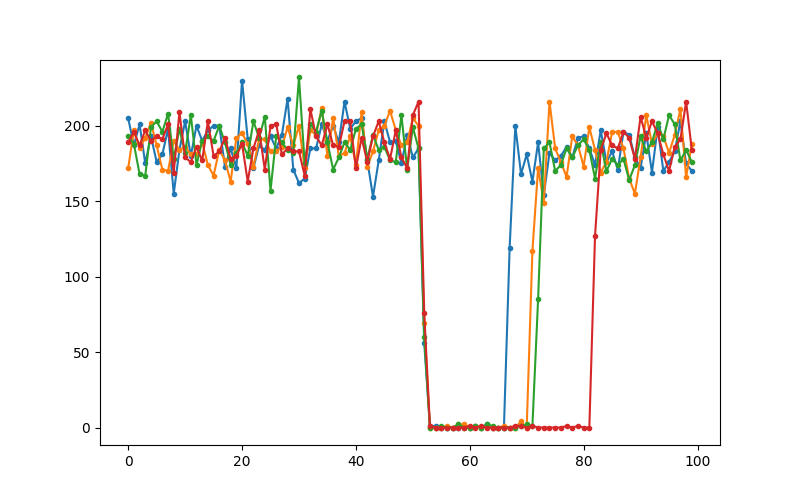

In [118]:

plt.figure(figsize=(8, 5))
a_scan = scan_data[0]
plt.plot(a_scan[1][200:300], '.-', label='Data')

a_scan = scan_data[4]
plt.plot(a_scan[1][200:300], '.-', label='Data')

a_scan = scan_data[5]
plt.plot(a_scan[1][200:300], '.-', label='Data')

a_scan = scan_data[15]
plt.plot(a_scan[1][200:300], '.-', label='Data')

In [116]:
a_scan[1].shape[0]/2

280.0

In [120]:
def bespoke_measure_contrast(data_buffer, experiment):
    trace = qt3utils.experiments.common.aggregate_sum(data_buffer, experiment)
    background = trace[2:202]
    signal = trace[len(trace)//2+2:len(trace)//2+202]
    return np.sum(signal)/np.sum(background)

In [122]:
scan_data = ramsey_experiment.run(N_cycles=10000, post_process_function=bespoke_measure_contrast)

INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 1e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 1.2e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 1.4e-06 seconds
C:\Users\adamcox\anaconda3\envs\dev1\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<DB>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\adamcox\anaconda3\envs\dev1\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<DC>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\adamcox\anaconda3\envs\dev1\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<DD>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\adamcox\anaconda3\envs\dev1\li

INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 5.2e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 5.4e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 5.6e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 5.8e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 6e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 6.2e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 6.4e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 6.6e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 6.8e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 7e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 7.2e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 7.4e-06 seconds
INFO:qt3utils.experiments.ramsey:Free Precession Time, tau: 7.6e-06 seconds
INFO:qt3utils.ex

<IPython.core.display.Javascript object>


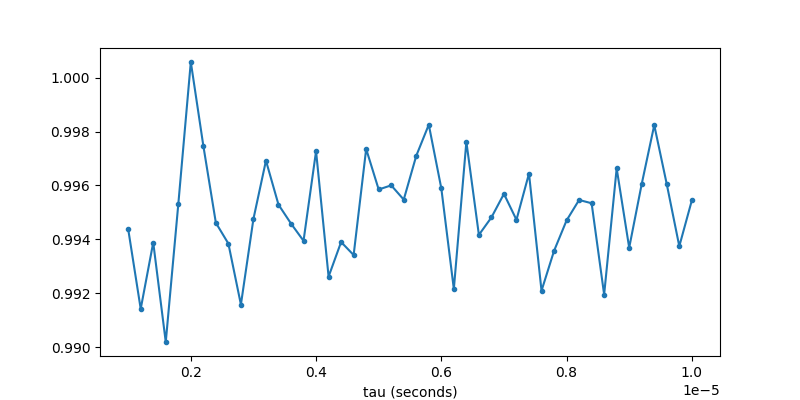

In [125]:
plot_contrast_scan(scan_data,xlabel='tau (seconds)', marker = '.-')

In [126]:
import copy

In [127]:
mirror_pulser = copy.deepcopy(ramsey_pulser)

In [128]:
mirror_pulser.__dict__

{'pb_board_number': 1,
 'aom_channel': 0,
 'rf_channel': 1,
 'clock_channel': 2,
 'trigger_channel': 3,
 'aom_width': 5e-05,
 'rf_pi_pulse_width': 1e-06,
 'aom_response_time': 8e-07,
 'rf_response_time': 2e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'full_cycle_width': 0.000124,
 'free_precession_time': 1e-05,
 'n_refocussing_pi_pulses': 0,
 'pi_pulse_start_times': [],
 'left_pi_over_2_pulse_start': None,
 'right_pi_over_2_pulse_start': None,
 'clock_period': 2e-07,
 'trigger_width': 5e-07,
 'rf_start_and_duration': [(5.0700000000000006e-05, 5e-07),
  (6.120000000000001e-05, 5e-07)]}

In [129]:
mirror_pulser.aom_channel = 16
mirror_pulser.rf_channel = 17
mirror_pulser.clock_channel = 18
mirror_pulser.trigger_channel = 19

In [134]:
ramsey_experiment.experimental_conditions()

{'tau_low': 1e-06,
 'tau_high': 1e-05,
 'tau_step': 2e-07,
 'rf_power': -25,
 'rf_frequency': 2788197230,
 'pulser': {'rf_pi_pulse_width': 1e-06,
  'aom_width': 5e-05,
  'aom_response_time': 8e-07,
  'post_rf_pad': 1e-07,
  'pre_rf_pad': 1e-07,
  'full_cycle_width': 0.000124,
  'free_precession_time': 1e-05,
  'clock_period': 2e-07}}

In [133]:
mirror_pulser.program_pulser_state(free_precession_time=10e-6)

620

In [132]:
mirror_pulser.start()

In [146]:
rabi_scan = {'scan_data':scan_data, 'experimental_conditions':rabiexperimental_conditionsp.experimental_conditions()}

save_file('rabi_scan_rfm25_8mus.oct28.2022.pickle', rabi_scan)